# Analyze Base Kit Strength

First, we will analyze just kit strength. 
We will create a model that predicts battle results based
only on the sum of the kit strengths of the two teams.
Besides ignoring player skills, this model will also ignore
synergies between kits on the same team, anti-synergies
between kits on opposite teams, game versions, maps,
and game modes.

In [1]:
import logging

logger = logging.getLogger("analyze_base_kit_strength_notebook")
logging.basicConfig(level=logging.INFO)

## Demo battle record creator
Here is a small battle record creator for refining the model

In [2]:
from battle_record import BattleRecord
from typing import Generator


def some_battle_records() -> Generator[BattleRecord, None, None]:
    from read_battle_records import battle_records_from_zip

    return battle_records_from_zip("2024-04-26.zip")

In [39]:
def three_days_battle_records() -> Generator[BattleRecord, None, None]:
    """Records for March 27 - April 26, 2024 inclusive"""
    from read_battle_records import battle_records_from_zip

    return battle_records_from_zip("2024-04-24-to-26-battles.zip")

In [3]:
def mar_apr_battle_records() -> Generator[BattleRecord, None, None]:
    """Records for March 27 - April 26, 2024 inclusive"""
    from read_battle_records import battle_records_from_zip

    return battle_records_from_zip("2024-mar-apr-battles.zip")

## Duplicate kit_only_model code

For the sake of not having to reload the libraries constantly, we will duplicate the code
from the `kit_only_model` function in the `battle_record_analysis` module. This will enable
faster iteration.

In [58]:
import numpy as np
import pytensor.tensor as tt
from battle_record_analysis import (
    all_kits_used,
    all_observed_kit_variables_and_battle_results,
)
import pymc as pm
from typing import Callable, Iterable


def kit_only_model(
    battle_record_creator: Callable[[], Iterable[BattleRecord]]
) -> pm.Model:
    """
    Create a PyMC3 model for the given battle record creator.

    Team strength is determined by the kits used by the team members.
    let A = alpha_strength and B = bravo_strength.
    prob_team_alpha_win = exp(a)/(exp(b)+exp(a))
    This can be rewritten as prob_team_alpha_win = (exp(a)/exp(b))/(1+(exp(a)/exp(b)))=inverse_logit(a-b)

    Here is the formula for each battle record:
    kit_strengths = pm.Exp("kit_strengths", 1, dims=("kits",))
    both_sides_kit_strengths = concatenate(kit_strengths, kit_strengths)
    The basic formula is prob_team_alpha_win for each battle = exp(
        dot(kit_strengths, observed_kits)
    )
    Kit strength's prior distributed as a normal variable with mean 1

    Args:
        battle_record_creator: A callable that returns an
            iterable of battle records (generally by re-opening the file)

    Returns:
        A PyMC3 model for the given battle record creator.
    """
    kits = sorted(all_kits_used(battle_record_creator()))
    kit_index = {kit: i for i, kit in enumerate(kits)}
    observed_kit_variables_alpha, observed_kit_variables_bravo, battle_results = (
        all_observed_kit_variables_and_battle_results(
            battle_record_creator(), kit_index
        )
    )
    shuffled_indices = np.random.permutation(battle_results.shape[0])

    logger.info(f"Done reading.")
    logger.info(f"Number of kits: {len(kits)}")
    logger.info(
        f"Shape of observed_kit_variables_alpha: {observed_kit_variables_alpha.shape}"
    )
    logger.info(
        f"Shape of observed_kit_variables_bravo: {observed_kit_variables_bravo.shape}"
    )
    logger.info(f"Shape of battle_results: {battle_results.shape}")

    coords = {"kits": kits}
    with pm.Model(coords=coords) as model:
        observed_kit_data_alpha = pm.Data(
            "observed_kit_data_alpha", observed_kit_variables_alpha[shuffled_indices]
        )
        observed_kit_data_bravo = pm.Data(
            "observed_kit_data_bravo", observed_kit_variables_bravo[shuffled_indices]
        )
        battle_results_data = pm.Data(
            "battle_results_data", battle_results[shuffled_indices]
        )

        starter_kit_strengths = pm.Normal("kit_strengths", mu=0, sigma=1, dims="kits")
        kit_strengths = tt.reshape(starter_kit_strengths, (1, -1))
        logger.info(f"Shape of kit_strengths: {kit_strengths.shape.eval()}")
        all_matches_kit_strengths = tt.repeat(
            kit_strengths,
            observed_kit_data_alpha.shape[0],
            axis=0,
        )
        logger.info(
            f"Shape of all_matches_kit_strengths: {all_matches_kit_strengths.shape.eval()}"
        )

        kit_contributions_alpha = all_matches_kit_strengths * observed_kit_data_alpha
        kit_contributions_bravo = all_matches_kit_strengths * observed_kit_data_bravo
        log_alpha_strength = tt.reshape(
            tt.sum(kit_contributions_alpha, axis=1), (-1, 1)
        )
        log_bravo_strength = tt.reshape(
            tt.sum(kit_contributions_bravo, axis=1), (-1, 1)
        )
        logger.info(f"Shape of log_alpha_strength: {log_alpha_strength.shape.eval()}")

        # Correct for the bias that team alpha wins more than team beta by estimating
        # the amount that alpha wins more often. Multiply this by alpha_win_prob so that
        # in an even match (by kit) - that is 50% by kit, alpha wins at a rate of
        # base_win_probability
        base_win_probability = pm.Beta("base_win_probability", alpha=0.57, beta=0.5)
        pm.Bernoulli(
            "base_win_likelihood", base_win_probability, observed=battle_results_data
        )

        alpha_win_prob = pm.invlogit(log_alpha_strength - log_bravo_strength)
        adjusted_win_prob = alpha_win_prob * (base_win_probability / 0.5)
        # Clip to between 0 and 1 (and exclude the endpoints since those can have unusual results)
        # The right way to do this is to select the priors appropriately to keep
        # the multiplied factor in range for the Bernoulli likelihood, but this is simple enough for now.
        clipped_adjusted_win_prob = tt.clip(adjusted_win_prob, 2**-18, 1 - (2**-18))
        pm.Bernoulli(
            "battle_results", p=clipped_adjusted_win_prob, observed=battle_results_data
        )

    return model

In [59]:
from pymc import HamiltonianMC

with kit_only_model(some_battle_records) as small_model:
    kit_only_trace = pm.sample(1000, tune=1000, progressbar=True)

Reading battles: 100%|██████████| 9.98M/9.98M [00:00<00:00, 17.6MBytes/s, 2024-04-26.csv]
Processing battle records: 0it [00:00, ?it/s]
Reading battles:   0%|          | 0.00/9.98M [00:00<?, ?Bytes/s]
Processing battle records: 5250it [00:00, 10458.63it/s]?Bytes/s, 2024-04-26.csv]
Reading battles: 100%|██████████| 9.98M/9.98M [00:00<00:00, 17.0MBytes/s, 2024-04-26.csv]
Processing battle records: 6095it [00:00, 10349.37it/s]
INFO:analyze_base_kit_strength_notebook:Done reading.
INFO:analyze_base_kit_strength_notebook:Number of kits: 120
INFO:analyze_base_kit_strength_notebook:Shape of observed_kit_variables_alpha: (6095, 120)
INFO:analyze_base_kit_strength_notebook:Shape of observed_kit_variables_bravo: (6095, 120)
INFO:analyze_base_kit_strength_notebook:Shape of battle_results: (6095, 1)
INFO:analyze_base_kit_strength_notebook:Shape of kit_strengths: [  1 120]
INFO:analyze_base_kit_strength_notebook:Shape of all_matches_kit_strengths: [6095  120]
INFO:analyze_base_kit_strength_notebook

Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 299 seconds.
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [60]:
import pickle

pickle.dump(kit_only_trace, open("2024-04-26.kit_only_trace.pkl", "wb"))

In [67]:
import arviz as az

az.summary(kit_only_trace, var_names=["kit_strengths"], fmt="wide")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kit_strengths[52gal],0.086,0.102,-0.110,0.274,0.010,0.007,115.0,246.0,1.02
kit_strengths[52gal_deco],0.111,0.117,-0.110,0.325,0.010,0.007,147.0,305.0,1.01
kit_strengths[96gal],-0.194,0.201,-0.565,0.185,0.010,0.007,413.0,1033.0,1.00
kit_strengths[96gal_deco],-0.100,0.144,-0.366,0.162,0.010,0.007,228.0,637.0,1.01
kit_strengths[bamboo14mk1],-0.136,0.183,-0.472,0.209,0.009,0.007,372.0,1273.0,1.01
...,...,...,...,...,...,...,...,...,...
kit_strengths[variableroller],-0.042,0.125,-0.274,0.199,0.009,0.007,175.0,538.0,1.01
kit_strengths[variableroller_foil],0.050,0.171,-0.267,0.377,0.009,0.007,339.0,978.0,1.01
kit_strengths[wakaba],0.016,0.106,-0.182,0.221,0.010,0.007,122.0,272.0,1.02
kit_strengths[wideroller],-0.332,0.241,-0.787,0.111,0.010,0.007,580.0,1622.0,1.00


array([[<Axes: title={'center': 'base_win_probability'}>,
        <Axes: title={'center': 'base_win_probability'}>],
       [<Axes: title={'center': 'kit_strengths'}>,
        <Axes: title={'center': 'kit_strengths'}>]], dtype=object)

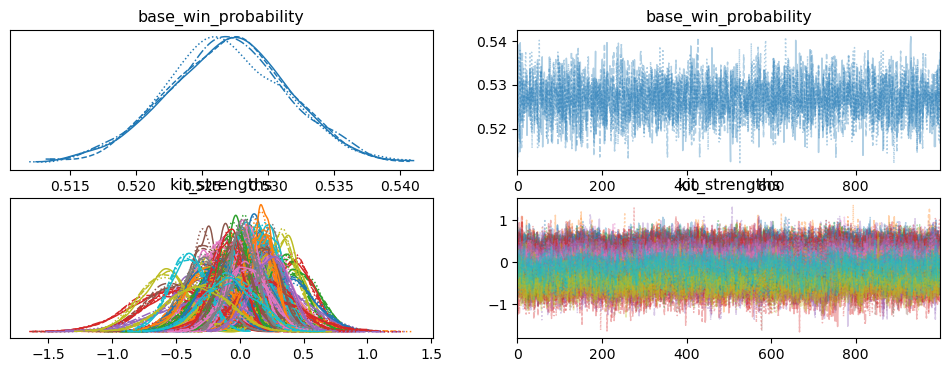

In [64]:
az.plot_trace(kit_only_trace)

In [ ]:
from pymc import HamiltonianMC

with kit_only_model(three_days_battle_records) as three_day_model:
    three_day_trace = pm.sample(3000, tune=2000, progressbar=True)

In [ ]:
import pickle

pickle.dump(
    three_day_trace,
    open("2024-04-24-to-2024-04-26.kit_only_trace_with_noise.pkl", "wb"),
)

In [ ]:
az.summary(three_day_trace)

In [ ]:
az.plot_trace(three_day_trace)

In [20]:
az.summary(mar_apr_kit_only_trace, var_names=["kit_strength"], fmt="long")

,weapons,weapon_strength
mean,52gal,0.088
mean,52gal_deco,0.105
mean,96gal,0.078
mean,96gal_deco,0.107
mean,bamboo14mk1,0.070
...,...,...
r_hat,variableroller,1.001
r_hat,variableroller_foil,1.001
r_hat,wakaba,1.000
r_hat,wideroller,1.001
